<a href="https://colab.research.google.com/github/ataSeyfi/comp4902/blob/main/Unet/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, PReLU,  LeakyReLU, Flatten, Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPool2D, Concatenate, Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,Adadelta, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive'
%cd '/content/drive/My Drive'

Mounted at /content/drive
 20220327_173301.jpg					    model_m15.keras
 app.py							    model_m16.keras
 checkpoint						    model_m17.keras
'Colab Notebooks'					    model_m18.keras
 dataset						    model_m19.keras
 digitalTransformation.gslides				    model_m1.keras
 index.html						    model_m1test.keras
 model_1new.h5						    model_m20.keras
 model_1pickle.pkl					    model_m2.2.keras
 model_deployment_test1.h5				    model_m2.3.keras
 model_deployment_test1.keras				    model_m2.keras
 model_deployment_test1_weights.data-00000-of-00001	    model_m2YEDEK.keras
 model_deployment_test1_weights.h5			    model_m3.3.keras
 model_deployment_test1_weights.index			    model_m3.keras
 model_deployment_test1_weights.keras			    model_m3Yedek.keras
 model_deployment_test1_weights_keras.data-00000-of-00001   model_m4.keras
 model_deployment_test1_weights_keras.index		    model_m5.2.keras
 model_m10.3.keras					    model_m5.3.keras
 model_m10.keras					    model_m5.keras
 model_m11.1.1.2.ker

#**INFECTION SEGMENTATION**

In [ ]:

train_dir = '/content/drive/My Drive/dataset/Infection Segmentation Data/Infection Segmentation Data/Train/'
test_dir = '/content/drive/My Drive/dataset/Infection Segmentation Data/Infection Segmentation Data/Test/'
val_dir = '/content/drive/My Drive/dataset/Infection Segmentation Data/Infection Segmentation Data/Val/'



In [ ]:


def create_dataframe_from_directory(data_dir):
    filenames, image_paths, mask_paths, labels = [], [], [], []

    for folder_name in os.listdir(data_dir):
        image_folder_path = os.path.join(data_dir, folder_name, 'images')
        mask_folder_path = os.path.join(data_dir, folder_name, 'infection masks')  # update the folder name

        image_list = sorted([filename for filename in os.listdir(image_folder_path)])
        mask_list = sorted([filename for filename in os.listdir(mask_folder_path)])

        for image_filename, mask_filename in zip(image_list, mask_list):
            image_list_path = os.path.join(folder_name, 'images', image_filename)
            mask_list_path = os.path.join(folder_name, 'infection masks', mask_filename)

            filenames.append(image_list_path)
            image_paths.append(os.path.join(image_folder_path, image_filename))
            mask_paths.append(os.path.join(mask_folder_path, mask_filename))
            labels.append(folder_name)

    return pd.DataFrame({
        'filename': filenames,
        'image_path': image_paths,
        'mask_path': mask_paths,
        'label': labels
    })

# Example usage:
train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)


In [ ]:
test_df

,filename,image_path,mask_path,label
0,COVID-19/images/covid_1579.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
1,COVID-19/images/covid_1582.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
2,COVID-19/images/covid_1583.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
3,COVID-19/images/covid_1584.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
4,COVID-19/images/covid_1585.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
...,...,...,...,...
1161,Normal/images/Normal (9768).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
1162,Normal/images/Normal (9769).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
1163,Normal/images/Normal (9770).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
1164,Normal/images/Normal (98).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal


In [ ]:
# Assuming the 'label' column contains the labels 'COVID-19', 'Non-COVID', and 'Normal'
label_counts = train_df['label'].value_counts()

# Display the occurrences
print(label_counts)

COVID-19     1864
Non-COVID     932
Normal        932
Name: label, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_with_masks(df, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        img_path = df['image_path'].iloc[i]
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        mask_path = df['mask_path'].iloc[i]
        mask = mpimg.imread(mask_path)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i + 1}")
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        overlay = cv2.addWeighted(img, 0.8, mask, 0.3, 0)
        plt.imshow(overlay)
        plt.title(f"Overlay {i + 1}")
        plt.axis('off')

    plt.show()

# Plotting COVID-19 cases from the training set
plot_images_with_masks(train_df[train_df['label'] == 'COVID-19'], title='Training Set - COVID-19 Cases')

# Plotting COVID-19 cases from the validation set
plot_images_with_masks(val_df[val_df['label'] == 'COVID-19'], title='Validation Set - COVID-19 Cases')

# Plotting COVID-19 cases from the test set
plot_images_with_masks(test_df[test_df['label'] == 'COVID-19'], title='Test Set - COVID-19 Cases')


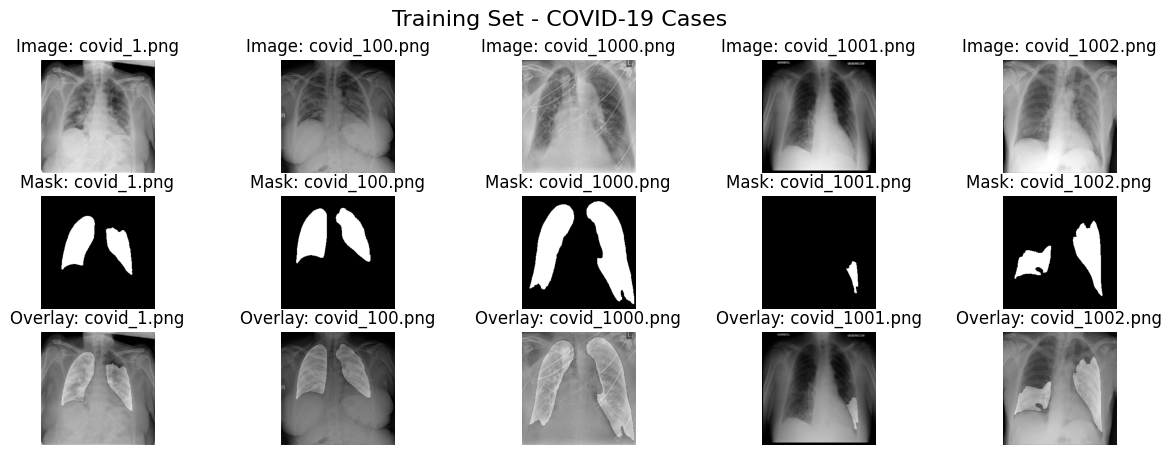

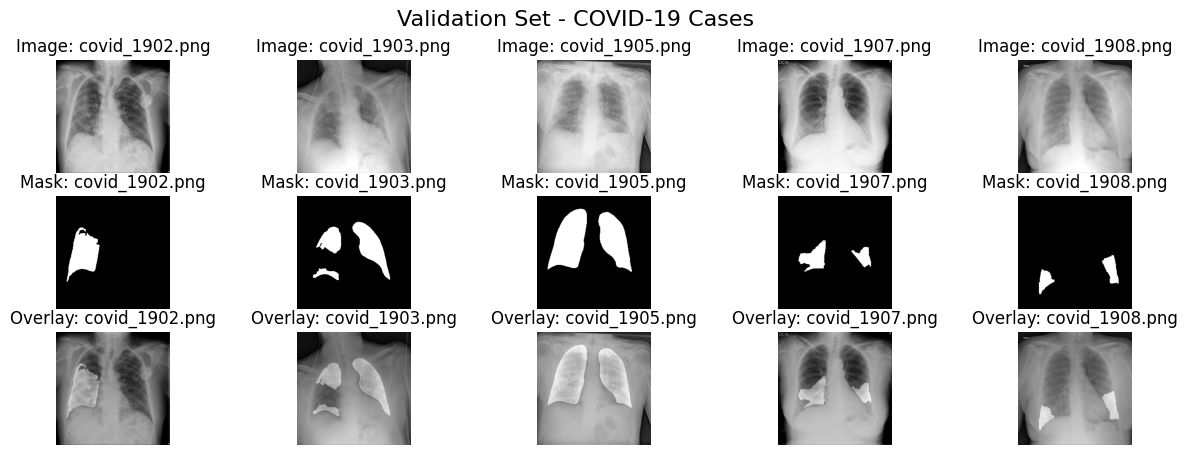

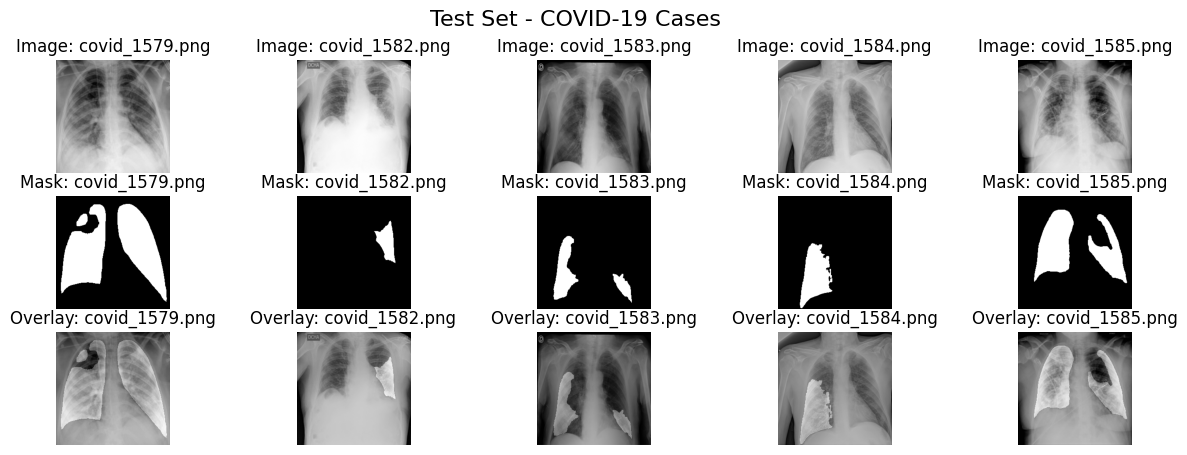

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_images_with_masks_cv2(df, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        img_path = df['image_path'].iloc[i]
        img_name = img_path.split("/")[-1]  # Extract the image name from the path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB
        plt.imshow(img)
        plt.title(f"Image: {img_name}")
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        mask_path = df['mask_path'].iloc[i]
        mask_name = mask_path.split("/")[-1]  # Extract the mask name from the path
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask: {mask_name}")
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        overlay = cv2.addWeighted(img, 0.8, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 0.3, 0)
        plt.imshow(overlay)
        plt.title(f"Overlay: {img_name}")
        plt.axis('off')

    plt.show()

# Plotting COVID-19 cases from the training set
plot_images_with_masks_cv2(train_df[train_df['label'] == 'COVID-19'], title='Training Set - COVID-19 Cases')

# Plotting COVID-19 cases from the validation set
plot_images_with_masks_cv2(val_df[val_df['label'] == 'COVID-19'], title='Validation Set - COVID-19 Cases')

# Plotting COVID-19 cases from the test set
plot_images_with_masks_cv2(test_df[test_df['label'] == 'COVID-19'], title='Test Set - COVID-19 Cases')


In [ ]:


def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = mask / 255.0  # Normalize pixel values to the range [0, 1]
    return mask



In [ ]:
train_df

,filename,image_path,mask_path,label
0,COVID-19/images/covid_1.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
1,COVID-19/images/covid_100.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
2,COVID-19/images/covid_1000.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
3,COVID-19/images/covid_1001.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
4,COVID-19/images/covid_1002.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
...,...,...,...,...
3723,Normal/images/Normal (2104).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3724,Normal/images/Normal (2105).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3725,Normal/images/Normal (2106).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3726,Normal/images/Normal (2107).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal


In [ ]:
import concurrent.futures

def preprocess_dataframe(df):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        df['image'] = list(executor.map(preprocess_image, df['image_path']))
        df['mask'] = list(executor.map(preprocess_mask, df['mask_path']))

# Preprocess the dataframes using parallel processing
preprocess_dataframe(train_df)
preprocess_dataframe(val_df)
preprocess_dataframe(test_df)

In [ ]:
# Explicitly shutdown the ThreadPoolExecutor
concurrent.futures.thread._threads_queues.clear()

In [ ]:
train_df = train_df[['label', 'image', 'mask']]
train_df.head()

,label,image,mask
0,COVID-19,"[[[0.4627450980392157, 0.4627450980392157, 0.4...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,COVID-19,"[[[0.0392156862745098, 0.0392156862745098, 0.0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,COVID-19,"[[[0.10588235294117647, 0.10588235294117647, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,COVID-19,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,COVID-19,"[[[0.023529411764705882, 0.023529411764705882,...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [ ]:

val_df = val_df[['label', 'image', 'mask']]
val_df.head()

,label,image,mask
0,COVID-19,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,COVID-19,"[[[0.06274509803921569, 0.06274509803921569, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,COVID-19,"[[[0.25098039215686274, 0.25098039215686274, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,COVID-19,"[[[0.18823529411764706, 0.18823529411764706, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,COVID-19,"[[[0.10588235294117647, 0.10588235294117647, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [ ]:

test_df = test_df[['label', 'image', 'mask']]
test_df.head()

,label,image,mask
0,COVID-19,"[[[0.403921568627451, 0.403921568627451, 0.403...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,COVID-19,"[[[0.0784313725490196, 0.0784313725490196, 0.0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,COVID-19,"[[[0.07450980392156863, 0.07450980392156863, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,COVID-19,"[[[0.6784313725490196, 0.6784313725490196, 0.6...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,COVID-19,"[[[0.00392156862745098, 0.00392156862745098, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [ ]:
# Count the occurrences of "COVID-19" in the 'label' column
count_covid_images = (test_df['label'] == 'COVID-19').sum()

# Count the occurrences of "Non-COVID" in the 'label' column
count_non_covid_images = (test_df['label'] == 'Non-COVID').sum()

# Count the occurrences of "Normal" in the 'label' column
count_normal_images = (test_df['label'] == 'Normal').sum()

# Display the counts
print("Count of COVID-19 NEGATIVE labeled images:", count_non_covid_images + count_normal_images)

print("Count of COVID-19 POSITIVE labeled images:", count_covid_images)

Count of COVID-19 NEGATIVE labeled images: 583
Count of COVID-19 POSITIVE labeled images: 583


In [ ]:




def create_unet(input_shape=(256, 256, 3), num_classes=1):
    # Define the VGG19 model without top layer
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder
    encoder = vgg19_base.get_layer('block5_conv4').output  # Use the output of the last convolutional layer in block5

    # Decoder
    decoder = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', activation='relu')(encoder)
    decoder = concatenate([vgg19_base.get_layer('block4_conv4').output, decoder], axis=-1)
    decoder = Conv2D(512, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(512, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([vgg19_base.get_layer('block3_conv4').output, decoder], axis=-1)
    decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([vgg19_base.get_layer('block2_conv2').output, decoder], axis=-1)
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([vgg19_base.get_layer('block1_conv2').output, decoder], axis=-1)
    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder)
    #decoder = Conv2D(num_classes, (1, 1), activation='softmax')(decoder)

    # Create the U-Net model
    unet_model = Model(inputs=vgg19_base.input, outputs=decoder)

    return unet_model

#translation, rotation,

In [ ]:

# Create the U-Net model
MODEL_UNET = create_unet()

# Display the model summary
MODEL_UNET.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

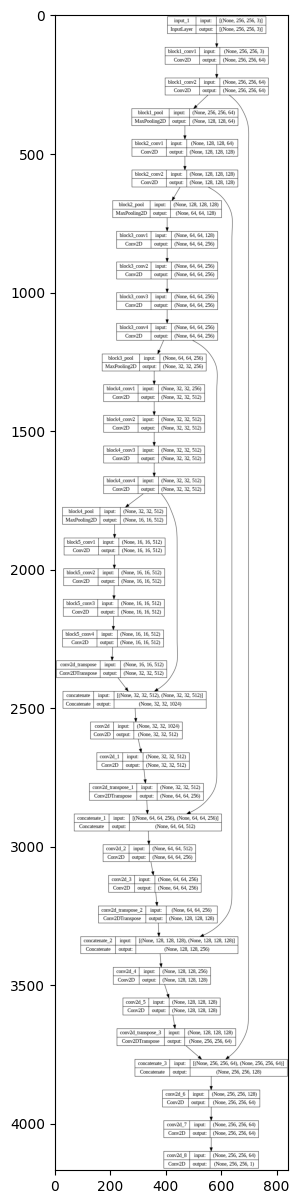

In [ ]:
from keras.utils import plot_model
import matplotlib.pyplot as plt


plot_model(MODEL_UNET, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

# Display the model architecture image
img = plt.imread('unet_model.png')
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()


In [ ]:
#unet_model.png

In [ ]:
def load_images_and_masks(df):
    images = []
    masks = []

    for index, row in df.iterrows():

        image = row['image']
        mask = row['mask']

        images.append(image)
        masks.append(mask)

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    return images, masks


In [ ]:

# Load images and masks for training data
x_train, y_train = load_images_and_masks(train_df)

# Load images and masks for validation data
x_val, y_val = load_images_and_masks(val_df)

# Load images and masks for test data
x_test, y_test = load_images_and_masks(test_df)

In [ ]:
y_train.shape

(3728, 256, 256, 1)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
MODEL_UNET.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#MODEL_UNET.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('unet_model_f5.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)





# Train the model
history = MODEL_UNET.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=4,
    epochs=40,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)



In [ ]:
#load model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('unet_model.h5')

In [ ]:
# Assuming you have x_test and y_test ready
test_loss, test_accuracy = loaded_model.evaluate(x_test, y_test, batch_size=4)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


292/292 [==============================] - 12s 27ms/step - loss: 0.0640 - accuracy: 0.9758
Test Loss: 0.0640
Test Accuracy: 0.9758


In [ ]:
x_test[0]

array([[[0.40392157, 0.40392157, 0.40392157],
        [0.41568627, 0.41568627, 0.41568627],
        [0.41568627, 0.41568627, 0.41568627],
        ...,
        [0.21568627, 0.21568627, 0.21568627],
        [0.14117647, 0.14117647, 0.14117647],
        [0.15294118, 0.15294118, 0.15294118]],

       [[0.40392157, 0.40392157, 0.40392157],
        [0.41568627, 0.41568627, 0.41568627],
        [0.42352941, 0.42352941, 0.42352941],
        ...,
        [0.23137255, 0.23137255, 0.23137255],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549]],

       [[0.38431373, 0.38431373, 0.38431373],
        [0.40784314, 0.40784314, 0.40784314],
        [0.41960784, 0.41960784, 0.41960784],
        ...,
        [0.27058824, 0.27058824, 0.27058824],
        [0.15686275, 0.15686275, 0.15686275],
        [0.12941176, 0.12941176, 0.12941176]],

       ...,

       [[0.62745098, 0.62745098, 0.62745098],
        [0.65882353, 0.65882353, 0.65882353],
        [0.6627451 , 0

In [ ]:
y_test[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

## PREDICTION

In [ ]:


# y_test is ground truth masks
binary_labels = np.array([1 if np.any(y_test[i] > 0.5) else 0 for i in range(len(y_test))])

# Display the binary labels
print(binary_labels)


[1 1 1 ... 0 0 0]


In [ ]:
# Count the occurrences of 1 in binary_labels
count_positive_labels = np.sum(binary_labels == 1)

# Display the count
print("Count of 1-labeled images:", count_positive_labels)

Count of 1-labeled images: 583


In [ ]:
y_test.shape

(1166, 256, 256, 1)

In [ ]:

predictions = loaded_model.predict(x_test)


37/37 [==============================] - 14s 208ms/step


In [ ]:
predictions.shape

(1166, 256, 256, 1)

In [ ]:
predictions

array([[[[8.21089256e-04],
         [8.93207034e-05],
         [1.64754092e-05],
         ...,
         [2.43694434e-08],
         [1.49347716e-06],
         [5.24618226e-05]],

        [[9.23199186e-05],
         [2.20628590e-05],
         [5.06568040e-06],
         ...,
         [1.80677995e-09],
         [2.16087784e-07],
         [5.86450824e-07]],

        [[2.93945377e-05],
         [4.69491488e-06],
         [6.34741355e-06],
         ...,
         [4.71935913e-09],
         [1.57803541e-07],
         [7.09961654e-08]],

        ...,

        [[2.60698696e-04],
         [2.75153172e-04],
         [9.43608989e-04],
         ...,
         [1.05113320e-01],
         [4.78770249e-02],
         [2.21895352e-02]],

        [[3.26311623e-04],
         [1.63436649e-04],
         [4.56670998e-04],
         ...,
         [6.59620017e-02],
         [1.61870085e-02],
         [2.15697326e-02]],

        [[2.01263931e-03],
         [6.93214475e-04],
         [9.20574996e-04],
         ...,
 

In [ ]:
test_lung_mask_dir = '/content/drive/My Drive/dataset/Infection Segmentation Data/Infection Segmentation Data/Test/'

def create_lung_mask_dataframe(data_dir):
    filenames, image_paths, lung_mask_paths, labels = [], [], [], []

    for folder_name in os.listdir(data_dir):
        image_folder_path = os.path.join(data_dir, folder_name, 'images')
        lung_mask_folder_path = os.path.join(data_dir, folder_name, 'lung masks')  # update the folder name

        image_list = sorted([filename for filename in os.listdir(image_folder_path)])
        lung_mask_list = sorted([filename for filename in os.listdir(lung_mask_folder_path)])

        for image_filename, lung_mask_filename in zip(image_list, lung_mask_list):
            image_list_path = os.path.join(folder_name, 'images', image_filename)
            lung_mask_list_path = os.path.join(folder_name, 'lung masks', lung_mask_filename)

            filenames.append(image_list_path)
            image_paths.append(os.path.join(image_folder_path, image_filename))
            lung_mask_paths.append(os.path.join(lung_mask_folder_path, lung_mask_filename))
            labels.append(folder_name)

    return pd.DataFrame({
        'filename': filenames,
        'image_path': image_paths,
        'lung_mask_path': lung_mask_paths,
        'label': labels
    })


lung_mask_df = create_lung_mask_dataframe(test_lung_mask_dir)


In [ ]:
lung_mask_df

,filename,image_path,lung_mask_path,label
0,COVID-19/images/covid_1579.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
1,COVID-19/images/covid_1582.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
2,COVID-19/images/covid_1583.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
3,COVID-19/images/covid_1584.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
4,COVID-19/images/covid_1585.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
...,...,...,...,...
1161,Normal/images/Normal (9768).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
1162,Normal/images/Normal (9769).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
1163,Normal/images/Normal (9770).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
1164,Normal/images/Normal (98).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal


In [ ]:
import cv2
import numpy as np

def preprocess_lung_mask(lung_mask_path):
    lung_mask = cv2.imread(lung_mask_path, cv2.IMREAD_GRAYSCALE)
    lung_mask = cv2.resize(lung_mask, (256, 256))
    lung_mask = np.expand_dims(lung_mask, axis=-1)  # Add channel dimension
    lung_mask = lung_mask / 255.0  # Normalize pixel values to the range [0, 1]
    return lung_mask

def create_processed_lung_mask_dataframe(lung_mask_df):
    filenames, processed_lung_masks = [], []

    for idx, row in lung_mask_df.iterrows():
        lung_mask = preprocess_lung_mask(row['lung_mask_path'])

        filenames.append(row['filename'])
        processed_lung_masks.append(lung_mask)

    return pd.DataFrame({
        'filename': filenames,
        'processed_lung_mask': processed_lung_masks
    })

# Example usage:
lung_mask_df = create_processed_lung_mask_dataframe(lung_mask_df)


In [ ]:
lung_mask_df = lung_mask_df["processed_lung_mask"]
lung_mask_df

0       [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
1       [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
2       [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
3       [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
4       [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
                              ...                        
1161    [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
1162    [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
1163    [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
1164    [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
1165    [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
Name: processed_lung_mask, Length: 1166, dtype: object

In [ ]:
import numpy as np


lung_mask_array = np.array(lung_mask_df.tolist())
lung_mask_array = lung_mask_array.astype(np.float32)  # Convert to float32
lung_mask_array = np.expand_dims(lung_mask_array, axis=-1)  # Add channel dimension


In [ ]:
lung_mask_array

array([[[[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]],


        ...,


        [[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]]],



       [[[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

   

In [ ]:
# WE WANT TO DETECT IF THE PREDICTED INFECTION MASKS ARE IN LUNG REGION

In [ ]:


# y_test is ground truth masks
binary_predictions = np.array([1 if np.any(predictions[i] > 0.5) else 0 for i in range(len(predictions))])

# Display the binary labels
print(binary_predictions)


[1 1 1 ... 0 0 0]


In [ ]:
# Count the occurrences of 1 in binary_labels
count_positive_predictions = np.sum(binary_predictions == 1)

# Display the count
print("Count of 1-labeled images:", count_positive_predictions)

Count of 1-labeled images: 655


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


flat_ground_truth = binary_labels.flatten()
flat_predictions = binary_predictions.flatten()



In [ ]:
flat_ground_truth

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# Calculate metrics
accuracy = accuracy_score(flat_ground_truth, flat_predictions)
precision = precision_score(flat_ground_truth, flat_predictions)
recall = recall_score(flat_ground_truth, flat_predictions)
f1 = f1_score(flat_ground_truth, flat_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_ground_truth, flat_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate specificity
specificity = tn / (tn + fp)

# Display the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Specificity: {specificity:.4f}')


Accuracy: 0.9228
Precision: 0.8763
Recall (Sensitivity): 0.9846
F1 Score: 0.9273
Specificity: 0.8611


In [ ]:
false_positive_indices = np.where((binary_labels == 0) & (binary_predictions == 1))[0]

print("False Positive Indices:", false_positive_indices)


False Positive Indices: [ 618  626  677  682  683  684  687  690  693  694  700  701  704  705
  707  710  713  715  717  720  721  723  724  728  729  733  740  743
  747  752  759  760  762  763  767  778  783  788  789  792  793  794
  795  798  800  804  805  807  808  813  814  817  823  824  827  828
  830  831  833  834  835  841  844  848  851  854  855  857  861  863
  865  906  935  940  947  959  961  970 1008 1040 1067]


In [ ]:
print(test_df.iloc[626])

filename                 Non-COVID/images/non_COVID (11950).png
image_path    /content/drive/My Drive/dataset/Infection Segm...
mask_path     /content/drive/My Drive/dataset/Infection Segm...
label                                                 Non-COVID
image         [[[0.0784313725490196, 0.0784313725490196, 0.0...
mask          [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
Name: 626, dtype: object


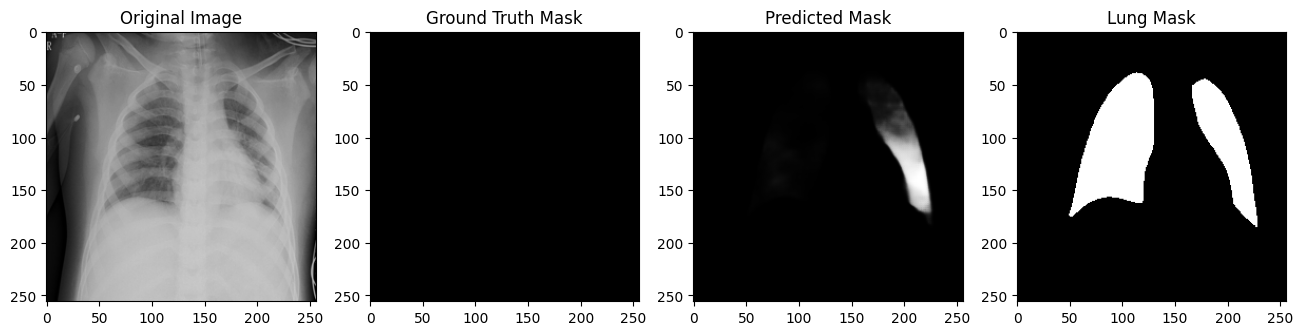

In [ ]:
import matplotlib.pyplot as plt

def plot_masks(original_image, ground_truth_mask, predicted_mask, lung_mask):
    plt.figure(figsize=(16, 6))

    # Plot original image
    plt.subplot(1, 4, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    # Plot ground truth mask
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth_mask[:, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')

    # Plot predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask[:, :, 0], cmap='gray')
    plt.title('Predicted Mask')

    # Plot lung mask
    plt.subplot(1, 4, 4)
    plt.imshow(lung_mask[:, :, 0], cmap='gray')
    plt.title('Lung Mask')

    plt.show()



plot_masks(x_test[626], y_test[626], predictions[626], lung_mask_array[626])


In [ ]:
#threshold ayarla
#lung mask kullanarak false positive düşür
# non-covid ve normal image augmentation

#**LUNG SEGMENTATION**